In [1]:
import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import gaussian_kde
from scipy.stats import gaussian_kde
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
datacsv          = "chuck august\\Mozambique_routing_results_20160817_01\\"
list_csv         = os.listdir(datacsv)

In [3]:
baseline = pd.read_csv("baseline_01_20160817_01.csv")
baseline.index = baseline.O.astype(str)+'_'+baseline.D.astype(str)

In [4]:
countrydata = pd.read_csv("chuck august\Mozambique_OD_locations_20160527_01.csv")

In [5]:
countrydata.head()

,INDEX_OD,INDEX_previous,OD_type,Name,LATITUDE,LONGITUDE,Road_processed,Has_no_road
0,0,0,text,text,-0.550000,-0.550000,NaN,NaN
1,1,1,seaport,BEIRA,-19.833333,34.833333,1,NaN
2,2,5,seaport,MAPUTO,-25.966667,32.583333,1,NaN
3,3,8,seaport,NACALA,-14.533333,40.666667,1,NaN
4,4,10,seaport,PEMBA,-12.966667,40.500000,1,NaN


In [6]:
baseline.head()

,O,D,Total_RUC,Total_Length,Total_Travel_time
1_67,1,67,1.399885,2.768213,0.095456
1_9,1,9,4.685011,12.004232,0.318301
1_64,1,64,45.432208,200.752788,2.043851
1_52,1,52,61.938492,288.933716,2.873062
1_51,1,51,87.053933,312.089782,4.571095


In [9]:
baseline = baseline.rename(columns={'Total_RUC':"TOTAL_RUC",\
                                    'Total_Length':'TOTAL_LENGTH'\
                                    ,'Total_Travel_time':'TOTAL_TRAVEL_TIME'})

In [10]:
traffic_xls = pd.read_excel("Mozambique_OD_locations_wTraffic_20160727.xls","Traffic_OD_matrix")

In [11]:
OD_info = pd.read_excel("Mozambique_OD_locations_wTraffic_20160823.xls","Mozambique_OD_locations_2016052")

In [12]:
OD_info.columns

Index(['INDEX_OD', 'INDEX_previous', 'OD_type', 'Name', 'LATITUDE',
       'LONGITUDE', 'Road_processed', 'Province', 'District', 'Study_area'],
      dtype='object')

In [13]:
OD_info = OD_info.rename(columns={'INDEX_OD':'road_index'})

In [14]:
road_info = pd.read_csv("MOZ_roads_all_20160817_ln_02d_wStudyArea.csv")

In [15]:
road_info.sample(4)

,SUM_RUC_km_total,MIN_Avg_speed,MAX_Traffic_analysis,SUM_Length_km,SUM_Travel_time,Road_index,study_area
31,0.426985,29,30,0.844345,0.029115,32,0
407,58.922395,29,56,131.151288,3.821157,408,0
424,53.747025,29,89,121.546851,3.457400,425,0
639,29.906237,29,56,66.407228,2.289904,640,1


In [16]:
traffic_xls.columns.name="D"
traffic_xls = traffic_xls.rename(columns={'OD_Traffic':'O'})

In [17]:
traffic = traffic_xls.set_index("O").unstack()

In [18]:
traffic.name = "traffic"

In [19]:
traffic = traffic.reset_index()
traffic.index = traffic.O.astype(str)+'_'+traffic.D.astype(str)

In [21]:
vul = pd.read_excel("crit_vuln_risk_database.xlsx")

In [23]:
vul.columns

Index(['FID', 'Shape *', 'OBJECTID', 'Dissolve_0', 'SUM_RUC_km', 'MIN_Avg_sp',
       'MAX_Traffi', 'SUM_Length', 'SUM_Travel', 'Road_index', 'Shape_Leng',
       'Max_WaterD', 'road_ind_1', 'missingrou', 'num_aff_ro', 'ruc_diff',
       'time_diff', 'km_diff', 'ruc_diff_w', 'crit_ruc_diff_w', 'WD_fCU5',
       'WD_fCU50', 'WD_fCU100', 'WD_fCC5', 'WD_fCC50', 'Wd_fCC100', 'WD_fLU5',
       'WD_fLU50', 'WD_fLU100', 'vuln_WD_fCU5', 'vuln_WD_fCU50',
       'vuln_WD_fCU100', 'vuln_WD_fCC5', 'vuln_WD_fCC50', 'vuln_Wd_fCC100',
       'vuln_WD_fLU5', 'vuln_WD_fLU50', 'vuln_WD_fLU100', 'risk_WD_fCU5',
       'risk_WD_fCU50', 'risk_WD_fCU100', 'risk_WD_fCC5', 'risk_WD_fCC50',
       'risk_Wd_fCC100', 'risk_WD_fLU5', 'risk_WD_fLU50', 'risk_WD_fLU100'],
      dtype='object')

In [30]:
vul = vul.rename(columns={'Road_index':'road_index'})

In [32]:
costs_all = pd.DataFrame(columns=["road_index","missingroutes","missinginstudyarea",\
                           "num_aff_routes","ruc_diff","time_diff","km_diff","ruc_diff_with_traffic"])
for file in list_csv:
    if ".csv" not in file:
        continue
    if "Mozambique" in file:
        continue
    if "Unrestricted" in file:
        continue
    scenar = pd.read_csv(datacsv+file)
    road   = (re.search('d(.*)_01_20160817_01.csv', file).group(1))
    #road = (re.search('d(.*)_(.*)_01_20160817_01.csv', file).group(2))
    scenar.index = scenar.O.astype(str)+'_'+scenar.D.astype(str)
    scenar['weights']=traffic.traffic

    missingroutes = len(baseline)-len(scenar)
    baseline_missing = baseline.ix[[i not in scenar.index for i in baseline.index],:]
    baseline_missing['OD_study_area'] = baseline_missing.O.replace(OD_info.set_index('road_index').Study_area)+\
                                        baseline_missing.D.replace(OD_info.set_index('road_index').Study_area)
    missinginstudyarea = sum(baseline_missing.OD_study_area>0)
    # we do not take into account the routes that don't have a second best solution
    baseline_nm = baseline.ix[[i in scenar.index for i in baseline.index],:]
    # we select only routes that get affected by the disruption
    affected_routes = (np.round(scenar.TOTAL_RUC/baseline_nm.TOTAL_RUC,3)!=1)&(baseline_nm.TOTAL_RUC>0)
    if sum(affected_routes)==0:
        costs_all.loc[len(costs_all),:] = [road,missingroutes,missinginstudyarea,sum(affected_routes),\
                                           0,0,0,0]
    else:
    
        subscenar = scenar.ix[affected_routes,:]

        diff_ruc_baseline   = (subscenar.TOTAL_RUC-\
                               baseline_nm.ix[affected_routes,"TOTAL_RUC"])
        diff_time_baseline   = (subscenar.TOTAL_TRAVEL_TIME-\
                               baseline_nm.ix[affected_routes,"TOTAL_TRAVEL_TIME"])
        diff_km_baseline = (subscenar.TOTAL_LENGTH-baseline_nm.ix[affected_routes,"TOTAL_LENGTH"])
        diff_tot_baseline   = (traffic.traffic*diff_ruc_baseline)

        ruc_diff  = np.sum(diff_ruc_baseline*subscenar.weights)/subscenar.weights.sum()
        time_diff = np.sum(diff_time_baseline*subscenar.weights)/subscenar.weights.sum()
        km_diff   = np.sum(diff_km_baseline*subscenar.weights)/subscenar.weights.sum()
        cost_with_traffic  = np.sum(diff_tot_baseline*subscenar.weights)/subscenar.weights.sum()

        costs_all.loc[len(costs_all),:] = [road,missingroutes,missinginstudyarea,sum(affected_routes),\
                                           ruc_diff,time_diff,km_diff,cost_with_traffic]

C:\Miniconda3\lib\site-packages\IPython\kernel\__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [47]:
costs_all.to_csv("results_0902.csv")

In [28]:
costs_all = pd.read_csv("results_0902.csv")

In [35]:
costs_all['study_area'] = costs_all.road_index.astype(float).replace(road_info.set_index('Road_index').study_area)

In [36]:
costs_all[["missingroutes","num_aff_routes","ruc_diff","time_diff","km_diff","ruc_diff_with_traffic"]].astype(float).describe()

,missingroutes,num_aff_routes,ruc_diff,time_diff,km_diff,ruc_diff_with_traffic
count,798.000000,798.000000,759.000000,759.000000,759.000000,759.000000
mean,32.233083,730.092732,13.726522,0.923087,33.226560,5689.818077
std,102.559715,1582.470818,22.593188,1.744767,63.064003,17025.496009
min,0.000000,0.000000,0.000000,-1.883032,-94.965278,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,42.000000,1.857616,0.007395,0.113191,19.360562
75%,0.000000,557.500000,17.422404,1.122672,42.277225,744.101591
max,762.000000,7670.000000,153.188461,11.686456,415.027741,153948.394227


In [38]:
def plot_histo(y,thecolor='blue',thelabel=''):    
    hist, bin_edges = np.histogram(y,bins=100,density=True)
    width = 0.5 * (bin_edges[1] - bin_edges[0])
    center = (bin_edges[:-1] + bin_edges[1:]) / 2
    if center.min()>0:
        xs = np.linspace(center.min()*0.85,center.max()*1.1,300)
    else:
        xs = np.linspace(center.min(),center.max(),300)
    #plt.bar(center, hist, align='center', width=width,alpha=0.05,color=thecolor)
    density = gaussian_kde(y)
    density._compute_covariance()
    plt.plot(xs,density(xs),linewidth=2,color=thecolor,label=thelabel)

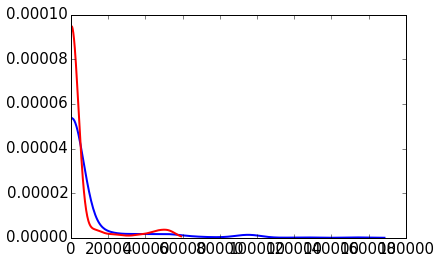

In [39]:
plot_histo(costs_all.ix[select,'ruc_diff_with_traffic'].astype(float).dropna(),'blue')
plot_histo(costs_all.ix[~select,'ruc_diff_with_traffic'].astype(float).dropna(),'red')

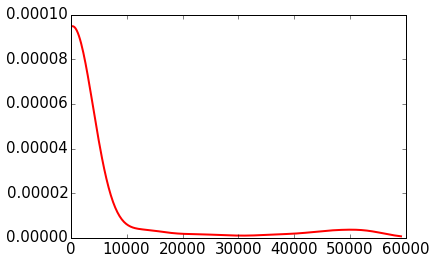

In [40]:
plot_histo(costs_all.ix[~select,'ruc_diff_with_traffic'].astype(float).dropna(),'red')

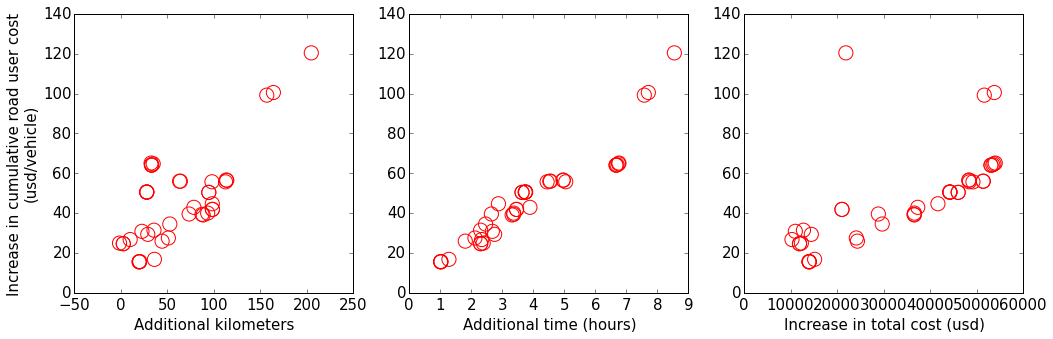

In [41]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(17,5))

select = (costs_all.study_area==1)&(costs_all.ix[:,'ruc_diff_with_traffic']>10000)

plt.subplot(131)
plt.scatter(costs_all.ix[select,'km_diff'].astype(float), costs_all.ix[select,'ruc_diff'].astype(float),\
           s=200, alpha=1,facecolors='none',edgecolors='red')
plt.xlabel("Additional kilometers")
plt.ylabel("Increase in cumulative road user cost\n(usd/vehicle)")

plt.subplot(132)
plt.scatter(costs_all.ix[select,'time_diff'].astype(float), costs_all.ix[select,'ruc_diff'].astype(float),\
           s=200, alpha=1,facecolors='none',edgecolors='red')
plt.xlabel("Additional time (hours)")

plt.subplot(133)
plt.scatter(costs_all.ix[select,'ruc_diff_with_traffic'].astype(float), costs_all.ix[select,'ruc_diff'].astype(float),\
           s=200, alpha=1,facecolors='none',edgecolors='red')
plt.xlabel("Increase in total cost (usd)")

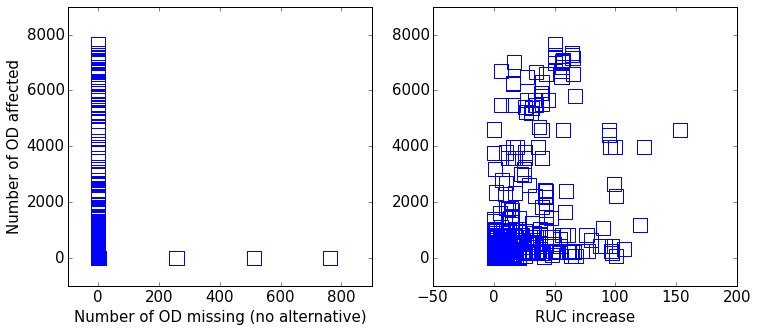

In [42]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.scatter(costs_all.missingroutes.astype(float), costs_all.num_aff_routes.astype(float),\
           s=200, alpha=1, marker='s',facecolors='none',edgecolors='blue')
plt.xlabel("Number of OD missing (no alternative)")
plt.ylabel("Number of OD affected")

plt.subplot(122)
plt.scatter(costs_all.ruc_diff.astype(float),costs_all.num_aff_routes.astype(float),\
           s=200, alpha=1, marker='s',facecolors='none',edgecolors='blue')
plt.xlabel("RUC increase")


In [46]:
costs_all.ix[(costs_all.missinginstudyarea.astype(float)>0)&(costs_all.study_area>0),["road_index","missinginstudyarea","study_area"]].drop_duplicates().to_csv("disruption_leads_to_missing_OD.csv",index=False)

In [143]:
costs_all.ix[(costs_all.missinginstudyarea.astype(float)>0)&(costs_all.study_area>0),["road_index","missinginstudyarea","study_area"]].drop_duplicates()

,road_index,missinginstudyarea,study_area
3,4,258,1
7,8,258,1
17,18,258,1
25,26,258,1
26,27,258,1
29,30,258,1
34,35,258,1
39,40,258,1
41,42,258,1
44,45,258,1


In [56]:
costs_all.ix[costs_all.num_aff_routes>0,:];

In [61]:
costs_all.road_index = costs_all.road_index.astype(int)

In [113]:
df = costs_all.merge(vul[['WD_fCU5','WD_fCU50', 'WD_fCU100', 'WD_fCC5', 'WD_fCC50', 'Wd_fCC100',\
                    'WD_fLU5','WD_fLU50', 'WD_fLU100','road_index']],on='road_index')

In [89]:
from itertools import cycle, islice
from matplotlib.ticker import FuncFormatter as funfor

In [90]:
def y_thousands_sep(ax=None):
    if ax is None:
        ax=plt.gca()
    ax.get_yaxis().set_major_formatter(funfor(lambda x, p: format(int(x), ',')))
    plt.tight_layout()

In [135]:
def savefig(path, **kwargs):
    #Saves in both png and pdf
    
    plt.tight_layout()
    
    path = path.replace(".png","")
    path = path.replace(".pdf","")

    plt.savefig(path+".png", )
    plt.savefig(path+".pdf", )

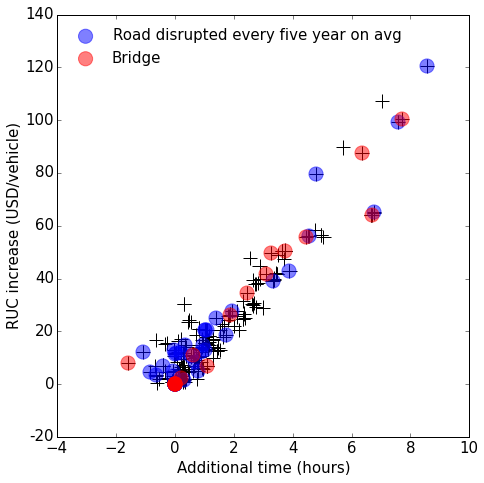

In [137]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(7,7))

select = df.study_area==1

flooded = (df.WD_fCU5>0.2)&(df.WD_fCU5!=999)

bridge = df.WD_fCU5==999

x = df.time_diff.astype(float)
y = df.ruc_diff.astype(float)

plt.subplot(111)
plt.scatter(x[select], y[select],s=200,marker='+', alpha=1,facecolors='none',edgecolors='black')

plt.scatter(x[select&flooded], y[select&flooded],s=200, alpha=0.5,facecolors='blue',edgecolors='blue',\
            label="Road disrupted every five year on avg")
plt.scatter(x[select&bridge], y[select&bridge],s=200, alpha=0.5,facecolors='red',edgecolors='red',\
            label="Bridge")

plt.legend(frameon=False,loc=2,scatterpoints=1,prop=font)
y_thousands_sep()

plt.xlabel("Additional time (hours)")
plt.ylabel("RUC increase (USD/vehicle)")

savefig("floods.png")

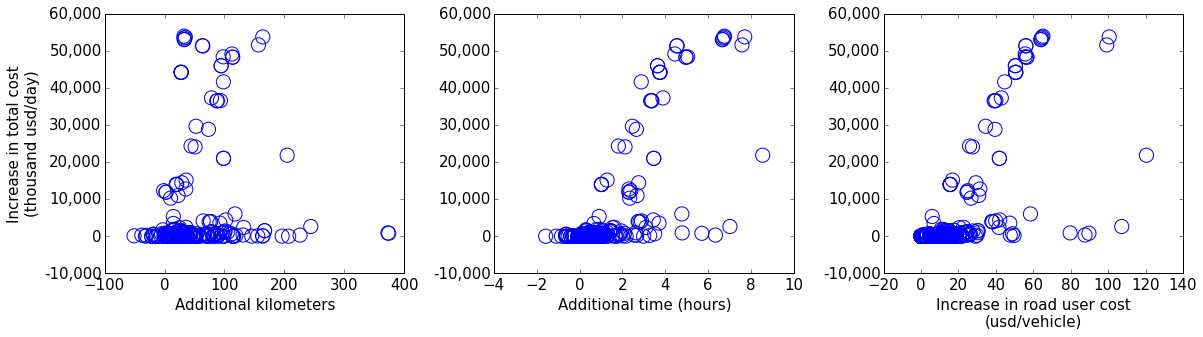

In [139]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(17,5))

select = costs_all.study_area==1

plt.subplot(131)
plt.scatter(costs_all.ix[select,'km_diff'].astype(float), costs_all.ix[select,'ruc_diff_with_traffic'].astype(float),\
           s=200, alpha=1,facecolors='none',edgecolors='blue')
plt.xlabel("Additional kilometers")
plt.ylabel("Increase in total cost\n(thousand usd/day)")
y_thousands_sep()

plt.subplot(132)
plt.scatter(costs_all.ix[select,'time_diff'].astype(float), costs_all.ix[select,'ruc_diff_with_traffic'].astype(float),\
           s=200, alpha=1,facecolors='none',edgecolors='blue')
plt.xlabel("Additional time (hours)")
y_thousands_sep()

plt.subplot(133)
plt.scatter(costs_all.ix[select,'ruc_diff'].astype(float), costs_all.ix[select,'ruc_diff_with_traffic'].astype(float),\
           s=200, alpha=1,facecolors='none',edgecolors='blue')
plt.xlabel("Increase in road user cost\n(usd/vehicle)")

y_thousands_sep()
savefig("criticality.png")

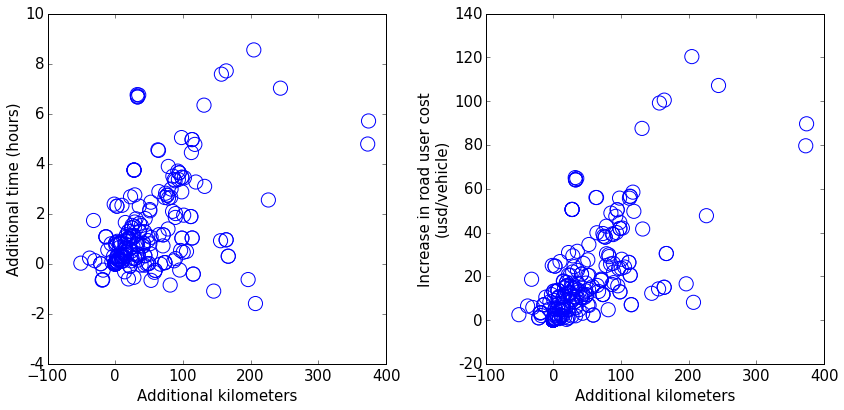

In [144]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(12,6))

select = costs_all.study_area==1

plt.subplot(121)
plt.scatter(costs_all.ix[select,'km_diff'].astype(float), costs_all.ix[select,'time_diff'],\
           s=200, alpha=1,facecolors='none',edgecolors='blue')
plt.xlabel("Additional kilometers")
plt.ylabel("Additional time (hours)")
y_thousands_sep()

plt.subplot(122)
plt.scatter(costs_all.ix[select,'km_diff'].astype(float), costs_all.ix[select,'ruc_diff'].astype(float),\
           s=200, alpha=1,facecolors='none',edgecolors='blue')
plt.xlabel("Additional kilometers")
plt.ylabel("Increase in road user cost\n(usd/vehicle)")
y_thousands_sep()

savefig("criticality2.png")